# How to Modify SAS9 Programs to Run in SAS Viya

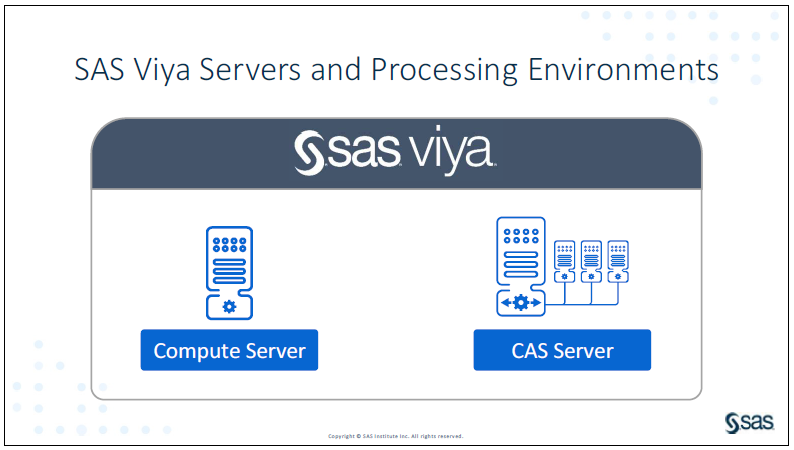

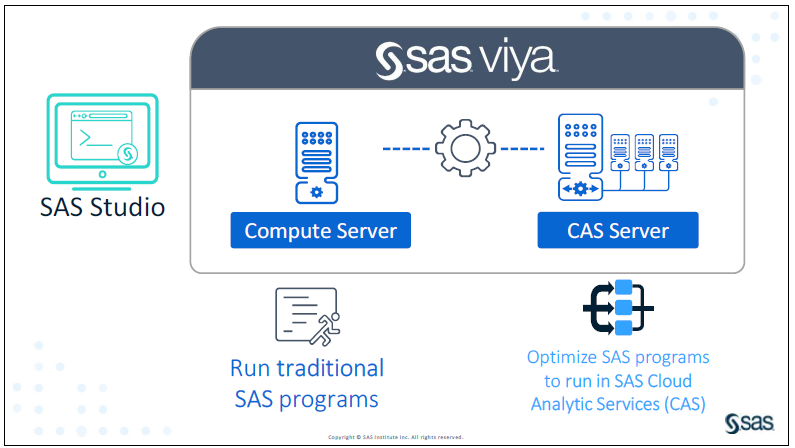

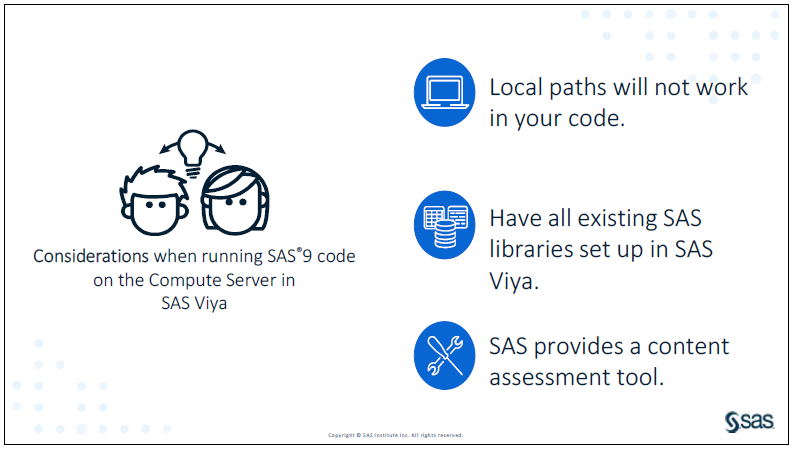

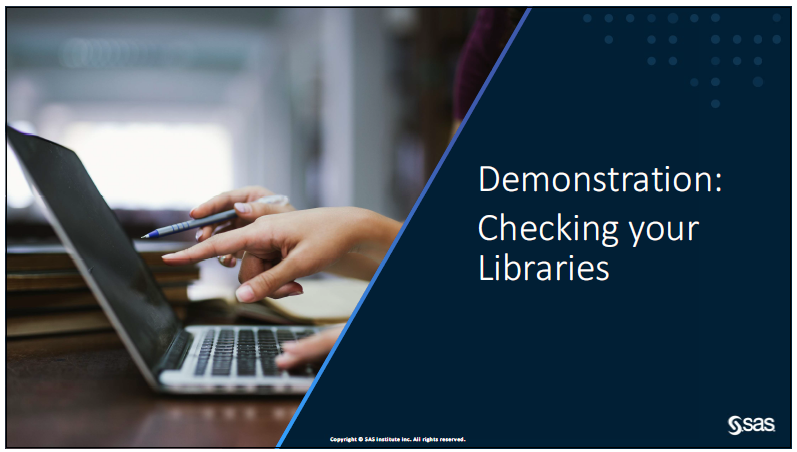

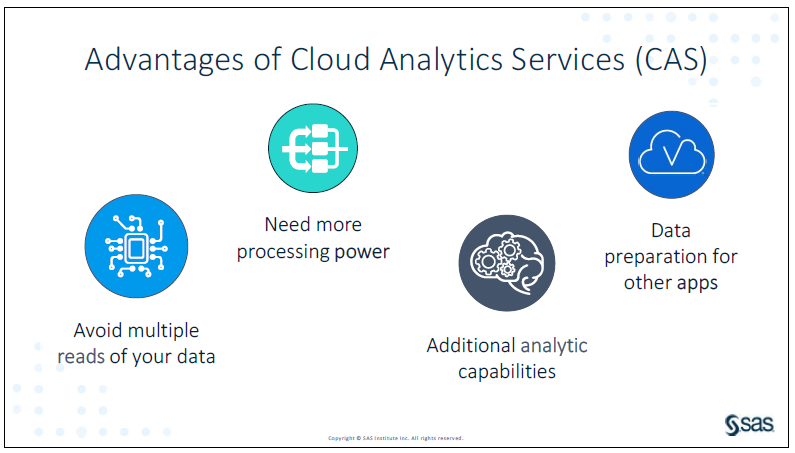

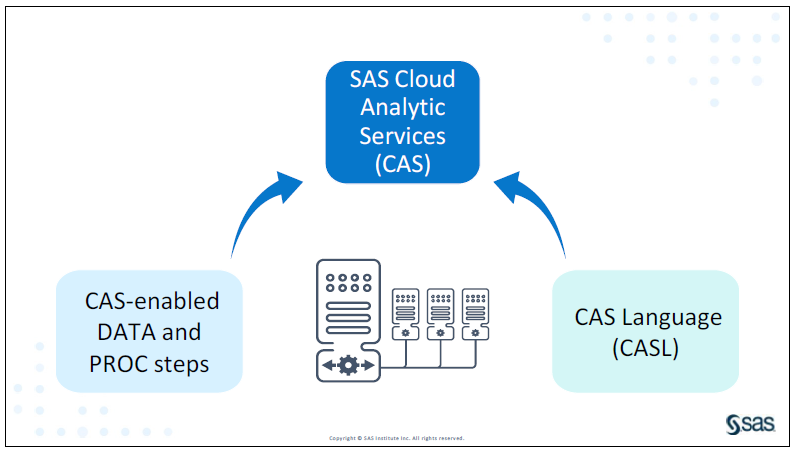

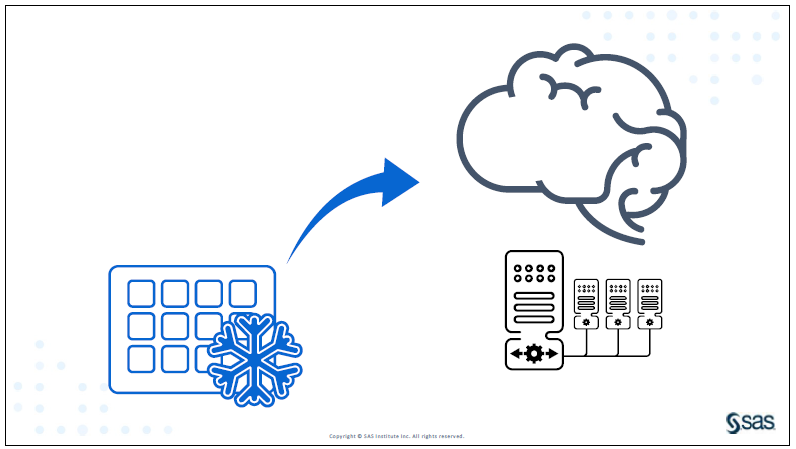

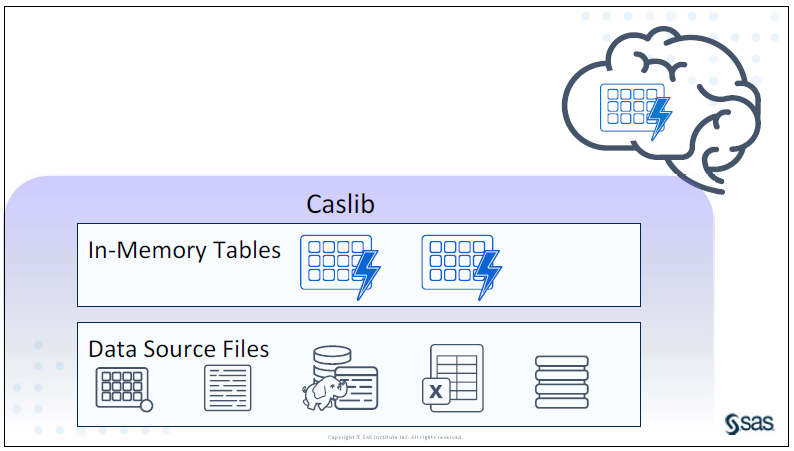

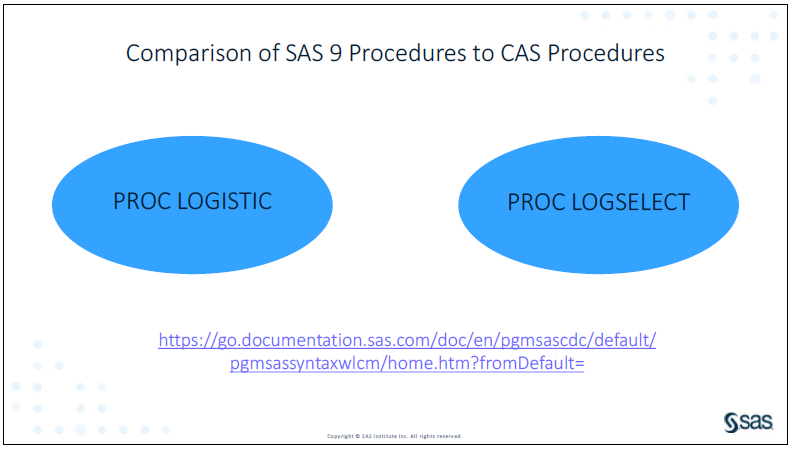

Link to [Comparison of PROCs to CAS Enabled PROCs]( https://go.documentation.sas.com/doc/en/pgmsascdc/default/pgmsassyntaxwlcm/home.htm?fromDefault= )

## PROC LOGISTIC (SAS9)

SAS server started using Context SAS Studio compute context with SESSION_ID=6c4315b6-e06b-402f-a89c-eedd3e64d976-ses0000



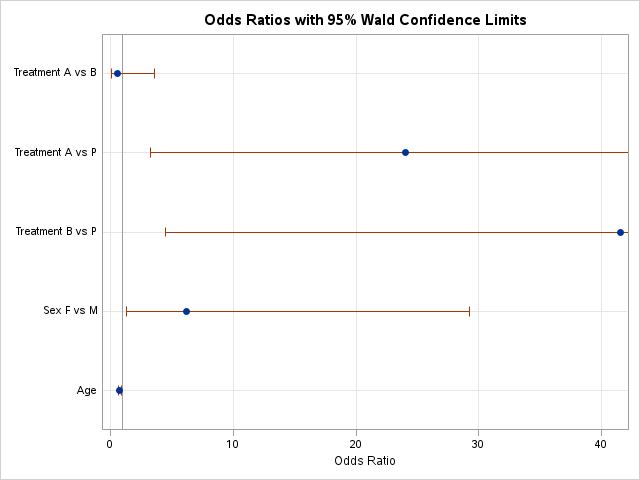
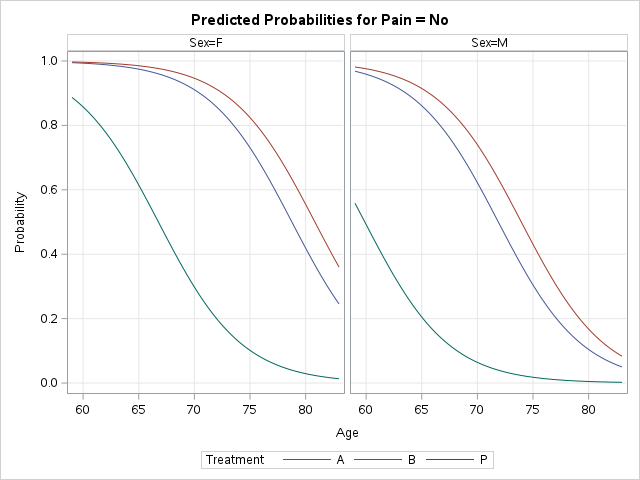
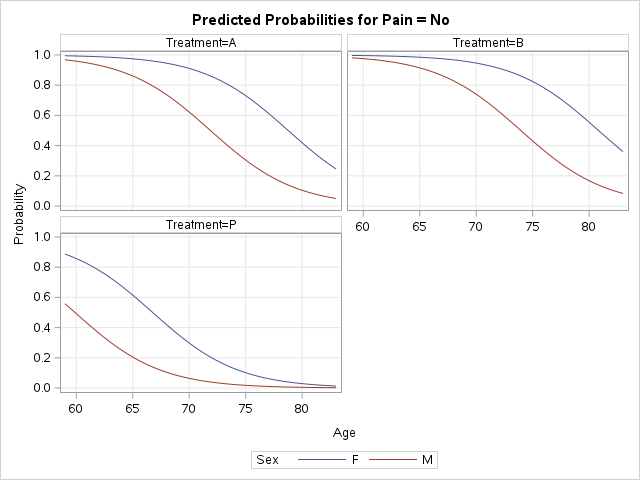

In [1]:
title 'PROC LOGISTIC: Modeling with Categorical Predictors';

data Neuralgia;
   input Treatment $ Sex $ Age Duration Pain $ @@;
   datalines;
P  F  68   1  No   B  M  74  16  No  P  F  67  30  No
P  M  66  26  Yes  B  F  67  28  No  B  F  77  16  No
A  F  71  12  No   B  F  72  50  No  B  F  76   9  Yes
A  M  71  17  Yes  A  F  63  27  No  A  F  69  18  Yes
B  F  66  12  No   A  M  62  42  No  P  F  64   1  Yes
A  F  64  17  No   P  M  74   4  No  A  F  72  25  No
P  M  70   1  Yes  B  M  66  19  No  B  M  59  29  No
A  F  64  30  No   A  M  70  28  No  A  M  69   1  No
B  F  78   1  No   P  M  83   1  Yes B  F  69  42  No
B  M  75  30  Yes  P  M  77  29  Yes P  F  79  20  Yes
A  M  70  12  No   A  F  69  12  No  B  F  65  14  No
B  M  70   1  No   B  M  67  23  No  A  M  76  25  Yes
P  M  78  12  Yes  B  M  77   1  Yes B  F  69  24  No
P  M  66   4  Yes  P  F  65  29  No  P  M  60  26  Yes
A  M  78  15  Yes  B  M  75  21  Yes A  F  67  11  No
P  F  72  27  No   P  F  70  13  Yes A  M  75   6  Yes
B  F  65   7  No   P  F  68  27  Yes P  M  68  11  Yes
P  M  67  17  Yes  B  M  70  22  No  A  M  65  15  No
P  F  67   1  Yes  A  M  67  10  No  P  F  72  11  Yes
A  F  74   1  No   B  M  80  21  Yes A  F  69   3  No
;

proc logistic data=Neuralgia;
   class Treatment Sex;
   model Pain= Treatment Sex Treatment*Sex Age Duration / expb;
run;

proc logistic data=Neuralgia;
   class Treatment Sex;
   model Pain=Treatment|Sex@2 Age Duration
         /selection=forward expb;
run;

ods graphics on;
proc logistic data=Neuralgia plots(only)=(oddsratio(range=clip));
   class Treatment Sex /param=ref;
   model Pain= Treatment Sex Age / noor;
   oddsratio Treatment;
   oddsratio Sex;
   oddsratio Age;
   contrast 'Pairwise A vs P' Treatment 1  0 / estimate=exp;
   contrast 'Pairwise B vs P' Treatment 0  1 / estimate=exp;
   contrast 'Pairwise A vs B' Treatment 1 -1 / estimate=exp;
   contrast 'Female vs Male' Sex 1 / estimate=exp;
   effectplot / at(Sex=all) noobs;
   effectplot slicefit(sliceby=Sex plotby=Treatment) / noobs;
run;

## PROC LOGSELECT (CAS enabled Procedure)

In [2]:
cas mySession sessopts=(caslib=casuser timeout=1800 locale="en_US");
libname casuser cas;

68   ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
68 ! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml1.htm
69   
70   cas mySession sessopts=(caslib=casuser timeout=1800 locale="en_US");
NOTE: The session MYSESSION connected successfully to Cloud Analytic Services sas-cas-server-default-client using port 5570. The 
      UUID is 0825d864-e98d-4846-97ee-84ab0eda5f55. The user is danny.modlin@sas.com and the active caslib is 
      CASUSER(danny.modlin@sas.com).
NOTE: The SAS option SESSREF was updated with the value MYSESSION.
NOTE: The SAS macro _SESSREF_ was updated with the value MYSESSION.
NOTE: The session is using 0 workers.
NOTE: 'CASUSER(danny.modlin@sas.com)' is now the active caslib.
NOTE: The CAS statement request to update one or more session options for session MYSESSION completed.
71   libname casuser cas;
NOTE: Libref CASUSER was successfully assigned as follows: 
      En


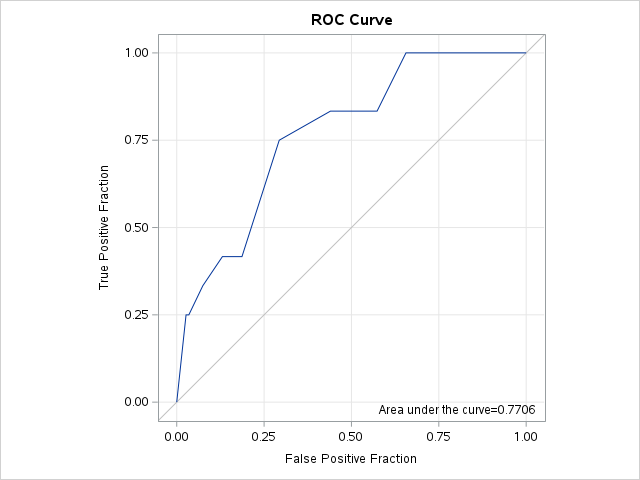

In [3]:
title 'PROC LOGSELECT: Modeling Binomial Data';

data Ingots;
   input Heat Soak r n @@;
   Obsnum= _n_;
   datalines;
7 1.0 0 10  14 1.0 0 31  27 1.0 1 56  51 1.0 3 13
7 1.7 0 17  14 1.7 0 43  27 1.7 4 44  51 1.7 0  1
7 2.2 0  7  14 2.2 2 33  27 2.2 0 21  51 2.2 0  1
7 2.8 0 12  14 2.8 0 31  27 2.8 1 22  51 4.0 0  1
7 4.0 0  9  14 4.0 0 19  27 4.0 1 16
;
data casuser.Ingots;
   set Ingots;
run;

proc logselect data=casuser.Ingots association ctable(out=casuser.Roc nocounts tpf fpf);
   model r/n = Heat Soak Heat*Soak;
   output out=casuser.Out xbeta predicted=Pred copyvars=(Heat Soak);
run;

proc print data=casuser.Out;
   where Heat=14 & Soak=1.7;
run;

ods graphics on;
proc sgplot data=casuser.Roc aspect=1 noautolegend;
   title 'ROC Curve';
   xaxis values=(0 to 1 by 0.25) grid offsetmin=.05 offsetmax=.05;
   yaxis values=(0 to 1 by 0.25) grid offsetmin=.05 offsetmax=.05;
   lineparm x=0 y=0 slope=1 / lineattrs=(color=ligr);
   series x=FPF y=TPF;
   inset 'Area under the curve=0.7706' / position=bottomright;
run;

data casuser.Ingots2;
   set Ingots;
   a = n - r;
run;

proc logselect data=casuser.Ingots2 association ctable(out=casuser.Roc nocounts tpf fpf);
   model r/a = Heat Soak Heat*Soak;
   output out=casuser.Out xbeta predicted=Pred copyvars=(Heat Soak);
run;

data casuser.Ingots_binary;
   set Ingots;
   do i=1 to n;
     if i <= r then y=1; else y = 0;
     output;
   end;
run;

proc logselect data=casuser.Ingots_binary;
   model y(event='1') = Heat Soak Heat*Soak;
run;

## Logistic Regression CAS Action

In [4]:
proc cas;
dataStep.runCode /
    code="
   data getStarted;
      nTotalObs=1000;
      drop c2 eta pr i rew nTotalObs nObsPerThread nExtras;
      call streaminit(1);
      nObsPerThread = int(nTotalObs/_nthreads_);
      nExtras       = mod(nTotalObs,_nthreads_);
      if _threadid_ <= nExtras then nObsPerThread = nObsPerThread + 1;
      do i=1 to nObsPerThread;
         id = (_threadid_ - 1) * nObsPerThread + i;
         if _threadid_ > nExtras then id = id + nExtras;
         rew = rand('rewind', id);
         x1=round(rand('normal')*5+10,.1); x2=round(7*rand('uniform'))/7;
         x3=round(rand('normal')*1+2,.1);  x4=round(50*rand('uniform'));
         x5=round(100*rand('uniform'));    x6=round(rand('normal')*.8+1.5,.1);
         x7=10*round(10*rand('uniform'));  x8=round(10*rand('uniform'))/10;
         x9=round(rand('normal')*3+5,.1);  x10=round(rand('normal')*2+3,.1);
         c2=rand('uniform');
         if      (c2<.1) then C='A'; else if (c2<.2) then C='B';
         else if (c2<.3) then C='C'; else if (c2<.4) then C='D';
         else if (c2<.5) then C='E'; else if (c2<.6) then C='F';
         else if (c2<.7) then C='G'; else if (c2<.8) then C='H';
         else if (c2<.9) then C='I'; else                 C='J';
         eta=1-x2-x8;
         pr= exp(eta)/(1+exp(eta));
         y=(rand('uniform') > pr);
         output;
      end;
   run;
   ",
    single="no";
run;

proc cas;
regression.logistic /
    class={"C"},
    model={depvar="y",
           effects={"C", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9",
                    "x10"}},
    optimization={itHist="summary"},
    outputTables={names={parameterestimates="pe"}},
    table="getStarted";
run;

proc cas;
regression.logistic /
    class={"C"},
    display={traceNames="true"},
    model={depvar="y",
           effects={"C", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9",
                    "x10"}},
    selection={details="all", method="forward"},
    table="getStarted";
run;

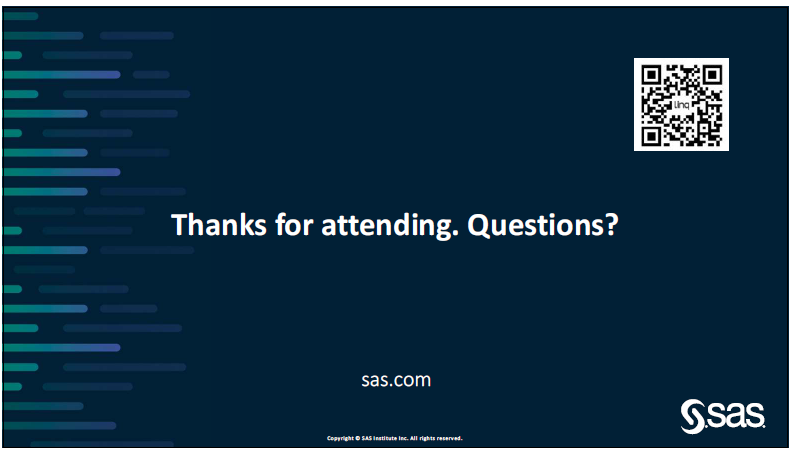